In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
import random
import os

In [38]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

## Define Networks

In [4]:
from models import encoder, unet, domain_classifyer, dann

s_encoder = encoder.get_model()
t_encoder = encoder.get_model()
u_net = unet.get_model()
d_decoder = domain_classifyer.get_model()
s_model = dann.SourceNet(
    source_encoder=s_encoder,
    unet=u_net
)

In [33]:
base_dir = "/home/gosha20777/Documents/Datasets/Zurich-RAW-to-DSLR-Dataset"
train_input_dir = os.path.join(base_dir, "train/huawei_raw")
train_target_dir = os.path.join(base_dir, "train/canon")
test_input_dir = os.path.join(base_dir, "test/huawei_raw")
test_target_dir = os.path.join(base_dir, "test/canon")
img_size = (224, 224)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".jpg")
    ]
)

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".png")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(test_target_dir, fname)
        for fname in os.listdir(test_target_dir)
        if fname.endswith(".jpg")
    ]
)


print("Number of samples:", len(input_img_paths))
print("Number test of samples:", len(test_input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))

Number of samples: 46839
Number test of samples: 1204
0.png | 0.jpg
1.png | 1.jpg
10.png | 10.jpg
100.png | 100.jpg
1000.png | 1000.jpg
10000.png | 10000.jpg
10001.png | 10001.jpg
10002.png | 10002.jpg
10003.png | 10003.jpg
10004.png | 10004.jpg


In [34]:
from datasets.huavei import HuaveiLoader

val_samples = 4000
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
val_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)
test_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, test_input_img_paths, test_target_img_paths
)

In [11]:
from losses.losses import mssim, vgg_loss

def main_loss(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred) + \
        mssim(y_true, y_pred) + \
        vgg_loss(y_true, y_pred)

def ssim(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

In [12]:
s_model.compile(optimizer="adam", metrics=[psnr, ssim], loss_fn=main_loss)

epochs = 4

callbacks = [
    keras.callbacks.ModelCheckpoint("s_model.h5", save_best_only=True)
]


s_model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks, workers=8)

2022-07-12 15:34:10.284529: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-07-12 15:34:11.247774: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2022-07-12 15:34:11.253055: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

In [13]:
print("Evaluate on test data")
_, psnr_val, ssim_val = s_model.evaluate(test_gen)
print(f"psnr: {psnr_val}, ssim: {ssim_val}")

Model: "source_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, None, None, 32)    6104      
_________________________________________________________________
model_7 (Functional)         [(None, None, None, 3), ( 7722787   
_________________________________________________________________
model_9 (Functional)         (None, None, None, 3)     7728891   
Total params: 7,728,891
Trainable params: 7,728,891
Non-trainable params: 0
_________________________________________________________________


## Domain Adaptation

In [35]:
base_dir = "/home/gosha20777/Documents/Datasets/MAI2021"
train_input_dir = os.path.join(base_dir, "mediatek_raw")
train_target_dir = os.path.join(base_dir, "fujifilm")
img_size = (128, 128)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png")
    ]
)


print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(os.path.basename(input_path), "|", os.path.basename(target_path))

Number of samples: 24161
0.png | 0.png
1.png | 1.png
10.png | 10.png
100.png | 100.png
1000.png | 1000.png
10000.png | 10000.png
10001.png | 10001.png
10002.png | 10002.png
10003.png | 10003.png
10004.png | 10004.png


In [36]:
from datasets.mai import MaiLoader

val_samples = 20000
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
target_train_gen = MaiLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
target_val_gen = MaiLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)

print("Number train samples:", len(train_input_img_paths))
print("Number val samples:", len(val_input_img_paths))

Number train samples: 4161
Number val samples: 20000


In [48]:
from datasets.dann import DannLoader

dann_train_gen = DannLoader(
    source_loader=train_gen,
    target_loader=target_train_gen
)

dann_val_gen = DannLoader(
    source_loader=val_gen,
    target_loader=target_val_gen
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


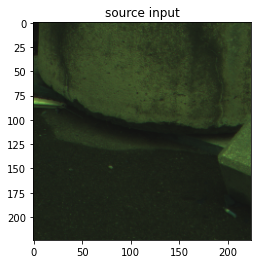

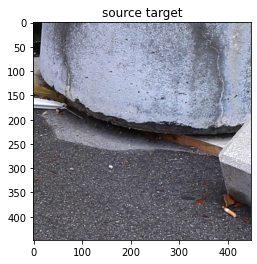

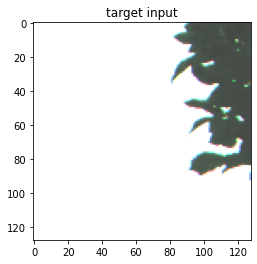

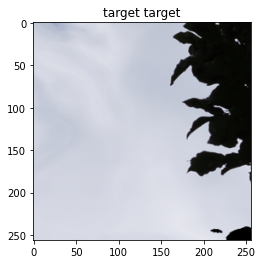

In [50]:
s_x, t_x, s_y, t_y, d_s_y, d_t_y = dann_val_gen.__getitem__(0)

plt_display(s_x[3][:,:,0:3], 'source input')
plt_display(s_y[3], 'source target')

plt_display(t_x[3][:,:,0:3], 'target input')
plt_display(t_y[3], 'target target')

In [47]:
s_model = dann.DannNet(
    source_encoder=s_encoder,
    target_encoder=t_encoder,
    unet=u_net,
    domain_classifyer=d_decoder
)